# Support Vector Machine

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("volkanastasia/dataset-of-used-cars")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dataset-of-used-cars' dataset.
Path to dataset files: /kaggle/input/dataset-of-used-cars


In [ ]:
import os

print("Dataset path:", path)
print("Files inside:")
print(os.listdir(path))

Dataset path: /kaggle/input/dataset-of-used-cars
Files inside:
['.nfs000000003ae0b3e600000063', 'car_data.csv']


In [ ]:
import pandas as pd

# Load data
df = pd.read_csv(os.path.join(path, "car_data.csv"))
print(df.shape) # check

(42089, 13)


Different C value

In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

# Sample for speed
df = df.sample(5000, random_state=42)

# Features & target
target_col = "car_price"
X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = [c for c in [
    "car_brand", "car_model", "car_city", "car_fuel",
    "car_transmission", "car_drive", "car_country"
] if c in X.columns]

numerical_cols = [c for c in [
    "car_mileage", "car_engine_capacity", "car_engine_hp", "car_age"
] if c in X.columns]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numerical_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
    ],
    remainder="drop",
)

# SVR inside a target transformer (log1p on y)
def build_model(C_value, gamma="scale", epsilon=0.2):
    svr = SVR(kernel="rbf", C=C_value, gamma=gamma, epsilon=epsilon)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("svr", svr)
    ])
    return TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,      # fit on log(price+1)
        inverse_func=np.expm1  # predict back to price units
    )

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Change C
C_values = [0.1, 1, 10, 100, 1000]

results = []
best = None

for C in C_values:
  model = build_model(C_value=C)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  results.append((C, r2, mae))
  if best is None or r2 > best["r2"]:
    best = {"C": C, "r2": r2, "mae": mae, "model": model}

# Summary
results_df = pd.DataFrame(results, columns=["C", "R2_Score", "MAE"]).sort_values(
    by="R2_Score", ascending=False
)
print(results_df.head(10))
print(f"\nBest: C={best['C']} → R²={best['r2']:.3f}, MAE={best['mae']:.2f}")


        C  R2_Score            MAE
1     1.0  0.902995  258623.349388
2    10.0  0.895459  264366.941551
3   100.0  0.894261  266541.570843
4  1000.0  0.889755  279041.607573
0     0.1  0.818474  296156.359220

Best: C=1 → R²=0.903, MAE=258623.35


Different epsilon

In [ ]:
df = pd.read_csv(os.path.join(path, "car_data.csv"))
df = df.sample(5000, random_state=42)

# Features & target
target_col = "car_price"
X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = [c for c in [
    "car_brand", "car_model", "car_city", "car_fuel",
    "car_transmission", "car_drive", "car_country"
] if c in X.columns]

numerical_cols = [c for c in [
    "car_mileage", "car_engine_capacity", "car_engine_hp", "car_age"
] if c in X.columns]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numerical_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
    ],
    remainder="drop",
)

# SVR inside a target transformer
def build_model(epsilon, C_value=1, gamma="scale"):
    svr = SVR(kernel="rbf", C=C_value, gamma=gamma, epsilon=epsilon)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("svr", svr)
    ])
    return TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    )

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Change epsilon
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

results = []
best = None

for e in epsilon_values:
  model = build_model(epsilon=e)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  results.append((e, r2, mae))
  if best is None or r2 > best["r2"]:
    best = {"Epsilon": e, "r2": r2, "mae": mae, "model": model}

# Summary
results_df = pd.DataFrame(results, columns=["Epsilon", "R2_Score", "MAE"]).sort_values(
    by="R2_Score", ascending=False
)
print(results_df.head(10))
print(f"\nBest: Epsilon={best['Epsilon']} → R²={best['r2']:.3f}, MAE={best['mae']:.2f}")

   Epsilon  R2_Score            MAE
0     0.01  0.928948  232404.925985
1     0.05  0.928003  231758.117821
2     0.10  0.924260  236662.176442
3     0.20  0.902995  258623.349388
4     0.50  0.831242  338179.392491
5     1.00  0.610962  524285.944052

Best: Epsilon=0.01 → R²=0.929, MAE=232404.93


Different gamma

In [ ]:
df = pd.read_csv(os.path.join(path, "car_data.csv"))
df = df.sample(5000, random_state=42)

# Features & target
target_col = "car_price"
X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = [c for c in [
    "car_brand", "car_model", "car_city", "car_fuel",
    "car_transmission", "car_drive", "car_country"
] if c in X.columns]

numerical_cols = [c for c in [
    "car_mileage", "car_engine_capacity", "car_engine_hp", "car_age"
] if c in X.columns]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numerical_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
    ],
    remainder="drop",
)

# SVR inside a target transformer
def build_model(gamma, epsilon=0.01, C_value=1):
    svr = SVR(kernel="rbf", C=C_value, gamma=gamma, epsilon=epsilon)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("svr", svr)
    ])
    return TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    )

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Try different gamma values
gamma_values = ["scale", "auto", 0.01, 0.05, 0.1, 0.5, 1]
results = []
best = None

for g in gamma_values:
  model = build_model(gamma=g)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  results.append((g, r2, mae))
  if best is None or r2 > best["r2"]:
    best = {"gamma": g, "r2": r2, "mae": mae, "model": model}

# Summary
results_df = pd.DataFrame(results, columns=["gamma", "R2_Score", "MAE"]).sort_values(
    by="R2_Score", ascending=False
)
print(results_df.head(10))
print(f"\nBest: gamma={best['gamma']} → R²={best['r2']:.3f}, MAE={best['mae']:.2f}")



   gamma  R2_Score            MAE
4    0.1  0.929137  232218.442500
0  scale  0.928948  232404.925985
3   0.05  0.923516  230974.560900
2   0.01  0.906864  244133.604558
1   auto  0.837167  313195.819476
5    0.5  0.645471  358444.376206
6      1  0.251177  642721.241002

Best: gamma=0.1 → R²=0.929, MAE=232218.44


Different kernel

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

df = pd.read_csv(os.path.join(path, "car_data.csv"))
df = df.sample(5000, random_state=42)

# Features & target
target_col = "car_price"
X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = [c for c in [
    "car_brand", "car_model", "car_city", "car_fuel",
    "car_transmission", "car_drive", "car_country"
] if c in X.columns]

numerical_cols = [c for c in [
    "car_mileage", "car_engine_capacity", "car_engine_hp", "car_age"
] if c in X.columns]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numerical_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
    ],
    remainder="drop",
)

# SVR inside a target transformer
def build_model(kernel, gamma=0.1, epsilon=0.01, C_value=1):
    svr = SVR(kernel=kernel, C=C_value, gamma=gamma, epsilon=epsilon)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("svr", svr)
    ])
    return TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    )

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Try different kernels
kernels = ["linear", "poly", "rbf", "sigmoid"]
results = []
best = None

for k in kernels:
  model = build_model(kernel=k)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  results.append((k, r2, mae, rmse))
  if best is None or r2 > best["r2"]:
    best = {"kernel": k, "r2": r2, "mae": mae, "rmse": rmse, "model": model}

# Summary
results_df = pd.DataFrame(results, columns=["kernel", "R2_Score", "MAE", "RMSE"]).sort_values(
    by="R2_Score", ascending=False
)
print(results_df.head(10))
print(f"\nBest: kernel={best['kernel']} → R²={best['r2']:.4f}, MAE={best['mae']:.2f}, RMSE={best['rmse']:.2f}")


    kernel       R2_Score            MAE           RMSE
2      rbf   9.291368e-01   2.322184e+05   4.108699e+05
1     poly   9.050247e-01   2.445451e+05   4.756628e+05
0   linear   9.033782e-01   2.449533e+05   4.797682e+05
3  sigmoid -9.371092e+231  4.724860e+120  1.494132e+122

Best: kernel=rbf → R²=0.9291, MAE=232218.44, RMSE=410869.93


# How does the brand and model affect the price?

Brand

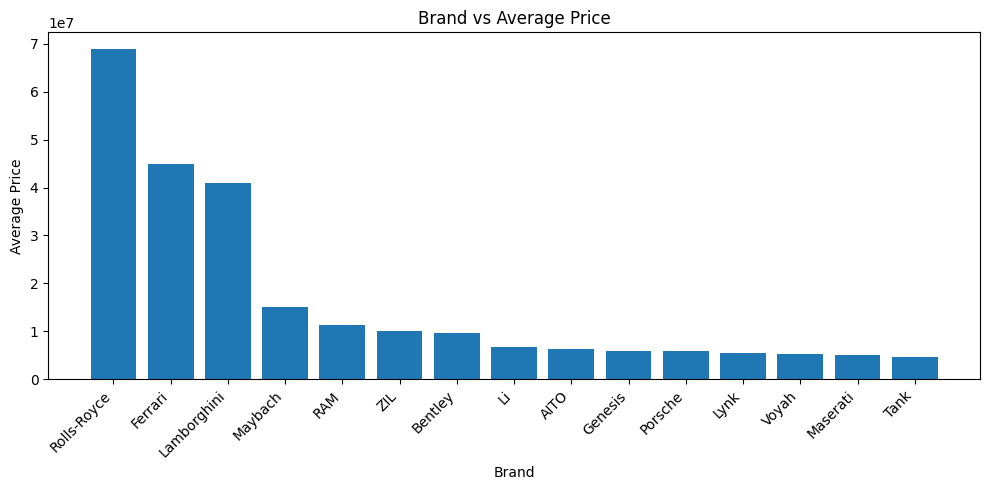

In [ ]:
# Load
df = pd.read_csv(os.path.join(path, "car_data.csv"))
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
# Preprocessing
df["car_price"] = pd.to_numeric(df["car_price"], errors="coerce")
df = df.dropna(subset=["car_brand", "car_model", "car_price"])
df = df[df["car_price"] > 0]

# ---- Brand vs Price (top 15 by average) ----
brand_avg = (df.groupby("car_brand")["car_price"]
               .mean()
               .sort_values(ascending=False)
               .head(15))

plt.figure(figsize=(10,5))
plt.bar(brand_avg.index, brand_avg.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.title("Brand vs Average Price")
plt.tight_layout()
plt.show()

Model

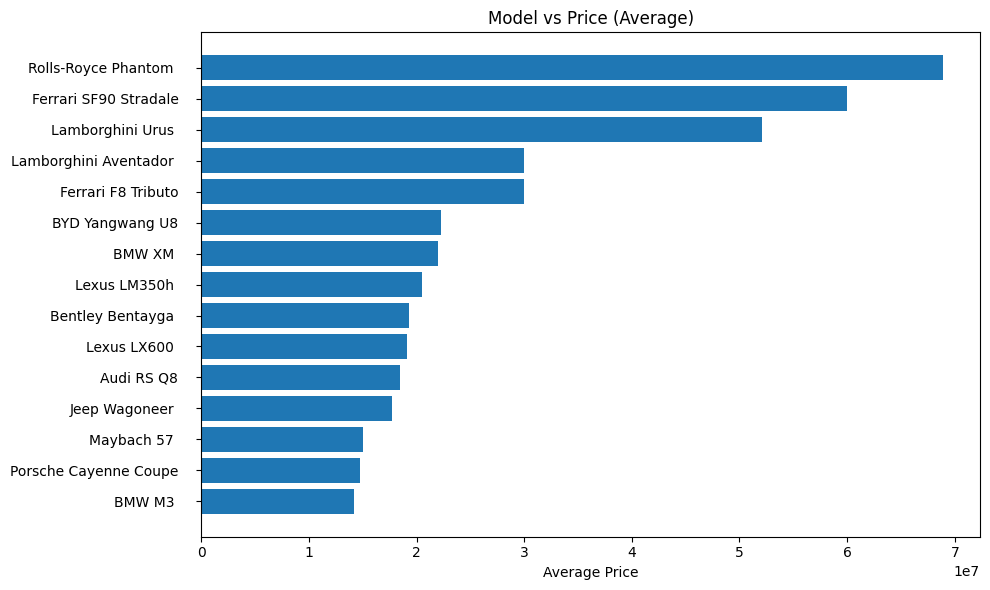

In [ ]:
# ---- Model vs Price (top 15 by average) ----
model_avg = (df.groupby(["car_brand","car_model"])["car_price"]
               .mean()
               .sort_values(ascending=False)
               .head(15)
               .reset_index())
model_avg["label"] = model_avg["car_brand"] + " " + model_avg["car_model"]

plt.figure(figsize=(10,6))
plt.barh(range(len(model_avg)), model_avg["car_price"].values)
plt.yticks(range(len(model_avg)), model_avg["label"].tolist())
plt.gca().invert_yaxis()
plt.xlabel("Average Price")
plt.title("Model vs Price (Average)")
plt.tight_layout()
plt.show()

# What models retain their value over a higher milage?


Top models (SVR-based, best retention vs mileage at median usage):
 car_brand       car_model  n_samples   r2_fit  pct_price_change_per_10k_km  median_price  median_mileage  median_age
      Lada        2109             74 0.223364                     2.547221      115000.0        154500.0        23.0
    Suzuki Grand Vitara            73 0.809103                     2.291398     1130000.0        196000.0        16.0
     Skoda        Yeti             71 0.598544                     1.983260     1200000.0        153331.0        11.0
    Toyota     Caldina            104 0.475464                     1.722420      399500.0        269500.0        25.0
Mitsubishi      Pajero            122 0.874522                     1.529729     1444950.0        215928.5        17.0
    Toyota       Hiace             96 0.808362                     1.474589     1700000.0        252500.0        17.0
    Toyota      Carina             72 0.571862                     1.366860      390000.0        262500.0 

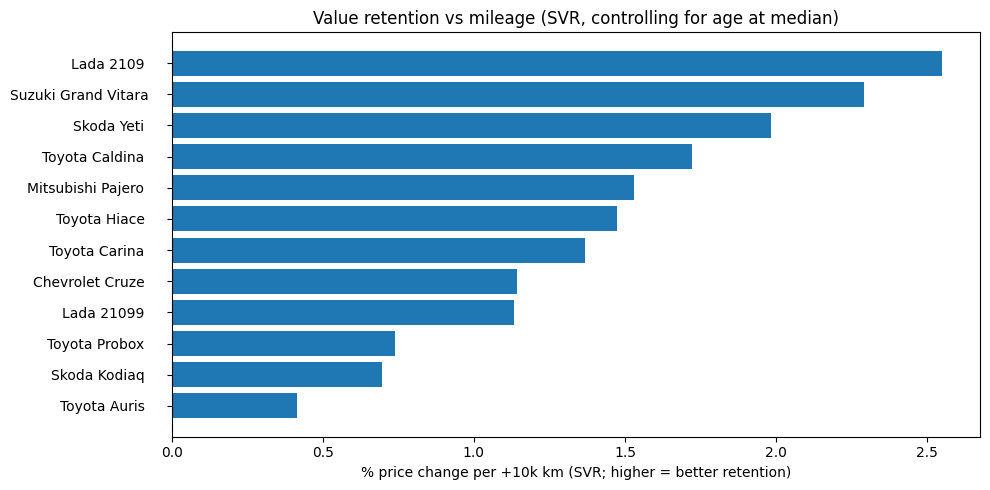

In [ ]:
# Here’s a super simple way to see which brand–models retain value better as mileage rises.
# It computes a slope of price vs. mileage (per +10k km) for each (brand, model).
# Slope near 0 (less negative) ⇒ better value retention.
# More negative ⇒ price drops faster with mileage.

import matplotlib.pyplot as plt

# Load & preprocess
df = pd.read_csv(os.path.join(path, "car_data.csv"))
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

for c in ["car_price","car_mileage","car_age"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["car_brand","car_model","car_price","car_mileage","car_age"])
df = df[(df["car_price"] > 0) & (df["car_mileage"] >= 0) & (df["car_age"] >= 0)].copy()

# Features
df["log_price"] = np.log1p(df["car_price"])
df["mileage_10k"] = df["car_mileage"] / 10000.0

# Settings
MIN_SAMPLES = 60          # need enough examples per model
MIN_M_STD   = 0.5         # at least 5k km std to have variation
C_VAL       = 1.0
EPS         = 0.1
GAMMA       = "scale"

rows = []
for (brand, model), g in df.groupby(["car_brand","car_model"], sort=False):
    if len(g) < MIN_SAMPLES:
        continue
    if g["mileage_10k"].std(ddof=0) < MIN_M_STD:
        continue

    X = g[["mileage_10k","car_age"]].to_numpy()
    y = g["log_price"].to_numpy()

    # SVR pipeline with scaling
    svr = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf", C=C_VAL, epsilon=EPS, gamma=GAMMA))
    ])
    svr.fit(X, y)

    r2 = r2_score(y, svr.predict(X))

    # Estimate marginal effect of +10k km at median mileage & age
    m_med = float(g["mileage_10k"].median())
    a_med = float(g["car_age"].median())

    X0 = np.array([[m_med, a_med]])
    X1 = np.array([[m_med + 1.0, a_med]])  # +10k km

    p0 = np.expm1(svr.predict(X0))[0]  # back to price units
    p1 = np.expm1(svr.predict(X1))[0]

    # % change per +10k km at median point
    pct_per_10k = (p1 - p0) / p0 * 100.0 if p0 > 0 else np.nan

    rows.append([
        brand, model, len(g), r2, pct_per_10k,
        float(g["car_price"].median()), float(g["car_mileage"].median()), a_med
    ])

res = pd.DataFrame(rows, columns=[
    "car_brand","car_model","n_samples","r2_fit",
    "pct_price_change_per_10k_km",
    "median_price","median_mileage","median_age"
]).dropna(subset=["pct_price_change_per_10k_km"])

# Rank: higher (less negative / closer to 0 or positive) = better retention
res = res.sort_values("pct_price_change_per_10k_km", ascending=False).reset_index(drop=True)

print("\nTop models (SVR-based, best retention vs mileage at median usage):")
print(res.head(20).to_string(index=False))

print("\nMost mileage-sensitive models (SVR-based):")
print(res.tail(20).to_string(index=False))

# Bar chart
top = res.head(12).copy()
labels = (top["car_brand"] + " " + top["car_model"]).tolist()
vals   = top["pct_price_change_per_10k_km"].values

plt.figure(figsize=(10,5))
plt.barh(range(len(top)), vals)
plt.yticks(range(len(top)), labels)
plt.gca().invert_yaxis()
plt.xlabel("% price change per +10k km (SVR; higher = better retention)")
plt.title("Value retention vs mileage (SVR, controlling for age at median)")
plt.tight_layout()
plt.show()

# What factors affect the price more than others?

Test R2 : 0.9338
Test MAE: 215212.21

Factor importance (% of total permutation importance) with SVR:
                 group   pi_mean  importance_%
0            car_brand  1.386630         91.40
1          car_mileage  0.046081          3.04
2  car_engine_capacity  0.044389          2.93
3              car_age  0.036445          2.40
4        car_engine_hp  0.003480          0.23


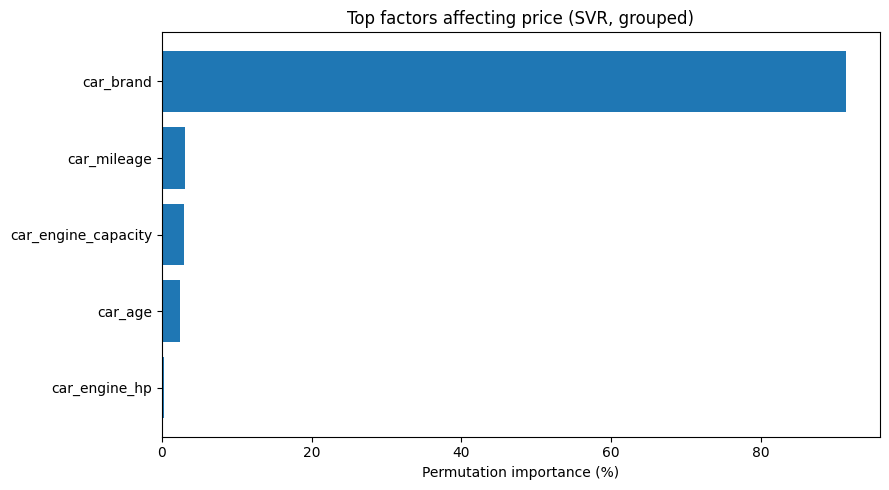

In [ ]:
# ========== What factors affect the price more than others? ==========
# Model-agnostic permutation importance with an SVR pipeline.
# Groups one-hot features back to original columns (brand, model, etc.).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# ---- Load & prep
df = pd.read_csv(os.path.join(path, "car_data.csv"))
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Coerce numerics
for c in ["car_price","car_mileage","car_engine_capacity","car_engine_hp","car_age"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["car_price"])
SAMPLE_N = 8000
if SAMPLE_N and len(df) > SAMPLE_N:
    df = df.sample(SAMPLE_N, random_state=42).reset_index(drop=True)

# Feature
X = df.drop(columns=["car_price"])
y = df["car_price"].values

cat_cols = [c for c in ["car_brand","car_model","car_city","car_fuel",
                        "car_transmission","car_drive","car_country"] if c in X.columns]
num_cols = [c for c in ["car_mileage","car_engine_capacity","car_engine_hp","car_age"] if c in X.columns]

# Check OneHotEncoder Version
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn < 1.2

pre = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
    ]), num_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe),
    ]), cat_cols),
], remainder="drop")

# SVR (with log1p target transform)
svr = SVR(kernel="rbf", C=1.0, epsilon=0.05, gamma="scale")  # tweak C/epsilon if desired
svr_pipe = Pipeline([("pre", pre), ("svr", svr)])
model = TransformedTargetRegressor(regressor=svr_pipe, func=np.log1p, inverse_func=np.expm1)

# Train/test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_tr, y_tr)

y_pred = model.predict(X_te)
print(f"Test R2 : {r2_score(y_te, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_te, y_pred):.2f}")

# Permutation importance (model-agnostic)
perm = permutation_importance(model, X_te, y_te, n_repeats=5, random_state=42, n_jobs=-1)

# Build transformed feature names
cat_names = []
if cat_cols:
    ohe_fit = model.regressor_.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
    cat_names = list(ohe_fit.get_feature_names_out(cat_cols))
feat_names = num_cols + cat_names

# Map transformed features -> original groups (full prefix match)
def parent_group(name: str) -> str:
    for col in cat_cols:
        prefix = col + "_"
        if name.startswith(prefix):
            return col
    return name  # numeric features keep their own name

imp_df = pd.DataFrame({
    "feature": feat_names[:len(perm.importances_mean)],
    "pi_mean": perm.importances_mean[:len(feat_names)],
    "pi_std":  perm.importances_std[:len(feat_names)],
})
imp_df["group"] = imp_df["feature"].map(parent_group)

group_imp = (imp_df.groupby("group")["pi_mean"]
                     .sum()
                     .sort_values(ascending=False)
                     .reset_index())

total = group_imp["pi_mean"].sum()
group_imp["importance_%"] = (100 * group_imp["pi_mean"] / (total if total else 1)).round(2)

print("\nFactor importance (% of total permutation importance) with SVR:")
print(group_imp)

# Bar chart (top 10)
topk = group_imp.head(10)
plt.figure(figsize=(9,5))
plt.barh(range(len(topk)), topk["importance_%"].values)
plt.yticks(range(len(topk)), topk["group"].tolist())
plt.gca().invert_yaxis()
plt.xlabel("Permutation importance (%)")
plt.title("Top factors affecting price (SVR, grouped)")
plt.tight_layout()
plt.show()